In [1]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import Tensor
import functools
import os
import numpy as np

import warnings
import glob


import io
from joblib import delayed 

from cacher import root, file_cached, mem_cached, clear_cache

import pymorphy2

from corus import load_lenta2
from navec import Navec
from razdel import tokenize, sentenize

from utils import ProgressParallel
from joblib import delayed

from utils import download_file

from slovnet.model.emb import NavecEmbedding

# from torchmetrics.functional.classification import binary_accuracy

import random
import string
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

def reverse_dict(d, priority_for_duplicates=[]):
    res = {val: key for key, val in d.items()}
    for key in priority_for_duplicates:
        res[d[key]] = key
    return res

def run_proc(task):
    import multiprocessing
    print("starting proc")
    p = multiprocessing.Process(target=task)
    try:
        p.start()
        p.join()
    except KeyboardInterrupt:
        print("terminating proccess")
        p.terminate()
        from time import sleep
        sleep(1)
        print("killing")
        p.kill()
torch.cuda.is_available(), torch.rand(10).to('cuda:0')

(True,
 tensor([0.8343, 0.2181, 0.1514, 0.9240, 0.2124, 0.7090, 0.9350, 0.6035, 0.3245,
         0.9577], device='cuda:0'))

In [2]:
from pymorphy2.tagset import OpencorporaTag

# https://pymorphy2.readthedocs.io/en/stable/user/grammemes.html
# http://opencorpora.org/dict.php?act=gram
# https://github.com/pymorphy2/pymorphy2/blob/92d546f042ff14601376d3646242908d5ab786c1/pymorphy2/tagset.py#L130
feature_tags_array = [
    OpencorporaTag.PARTS_OF_SPEECH, # часть речи
    OpencorporaTag.GENDERS, # род
    OpencorporaTag.NUMBERS, # число
    OpencorporaTag.CASES, # падеж
    OpencorporaTag.ASPECTS, # соверш / несоверш
    OpencorporaTag.TRANSITIVITY, # перех / непереходный
    OpencorporaTag.PERSONS, # лицо
    OpencorporaTag.TENSES, # время
    OpencorporaTag.MOODS, # наклонение
    OpencorporaTag.VOICES, # залог
    #INVOLVEMENT
    ['Prnt'], # вводные слова
    ['Apro'], # местоимение
    ['NUMB'], # число вида 1234
    ['LATIN'], # текст на английском
    ['UNKN'], # неизвестный токен
]

feature_tags_dict = {tag: i for i, tag in enumerate([item for sublist in feature_tags_array for item in sublist])}

len(feature_tags_dict)

53

In [3]:
VARIANTS_CNT = 2
FEATURES_CNT = len(feature_tags_dict) + 1
VARIANT_PROB_IDX = len(feature_tags_dict)

NO_PUNCT = 0
PUNCTUATION_TARGET = {
    "$empty": 0,
    ".": 1,
    "!": 1,
    "?": 1,
    ",": 2,
}
ID_TO_PUNCTUATION = reverse_dict(PUNCTUATION_TARGET, priority_for_duplicates=['.'])
TARGET_CLASSES_COUNT = 3

PUNCTUATION_ALL = string.punctuation

INPUT_WORDS_CNT = 5
INPUT_WORDS_CNT_LEFT = INPUT_WORDS_CNT // 2
INPUT_WORDS_CNT_RIGHT = INPUT_WORDS_CNT - INPUT_WORDS_CNT_LEFT

def empty_word_features():
    return torch.zeros([VARIANTS_CNT, FEATURES_CNT], dtype=torch.float32)

def get_word_features(word):
    res = empty_word_features()
    for i, variant in enumerate(morph.parse(word)[:VARIANTS_CNT]):
        for tag in variant.tag._grammemes_tuple:
            tag_index = feature_tags_dict.get(tag, None)
            if tag_index:
                res[i][tag_index] = True
        res[i][VARIANT_PROB_IDX] = variant.score
    return res

def build_input_and_output(text):
    input = []
    output = []

    for i in range(INPUT_WORDS_CNT_LEFT):
        input.append(empty_word_features())
        output.append(NO_PUNCT)

    for token in tokenize(text):
        s = token.text
        puntuation_idx = PUNCTUATION_TARGET.get(s, None)
        if puntuation_idx is not None:
            if output[-1] != NO_PUNCT: 
                # we are unable to handle double punctuation yey
                continue 
            output[-1] = puntuation_idx
            continue

        input.append(get_word_features(s))
        output.append(NO_PUNCT)

    for i in range(INPUT_WORDS_CNT_RIGHT):
        input.append(empty_word_features())
        output.append(NO_PUNCT)
    
    return torch.stack(input), torch.LongTensor(output)

def create_dataset_for_text(text):
    sampled_input = []
    sampled_output = [] 
    
    # input is (N_words, N_variants, N_features)
    # output is (N_words, )
    txt = text
    input, output = build_input_and_output(txt)

    for i in range(INPUT_WORDS_CNT_LEFT, len(input) - INPUT_WORDS_CNT_RIGHT):
        if output[i] != 0 or random.random() < 0.1:
            sampled_input.append(input[i - INPUT_WORDS_CNT_LEFT: i + INPUT_WORDS_CNT_RIGHT])
            sampled_output.append(output[i])
    if len(sampled_input) == 0: return None
    return torch.stack(sampled_input), torch.stack(sampled_output)

def create_dataset(texts):
    tasks = []
    for text in texts:
        tasks.append(delayed(create_dataset_for_text)(text))
    completed_tasks = ProgressParallel(n_jobs=16, total=len(tasks))(tasks)
    # for i, o in completed_tasks:
        # print(i.shape, o.shape)
    input, output = zip(*filter(lambda res: res is not None, completed_tasks))
    input_tensor, output_tensor = torch.cat(input), torch.cat(output)
    output_tensor = torch.nn.functional.one_hot(output_tensor, TARGET_CLASSES_COUNT)
    return input_tensor, output_tensor.float()
            
# input, output = create_dataset([
#     'Однако самые ранние свидетельства приручения кошек древними египтянами относились к 2000—1900 годам до нашей эры. А недавно было установлено, что в Древний Египет домашняя кошка попала, как и на Кипр, с территории Анатолии. В настоящее время кошка является одним из самых популярных домашних животных. ',
#     'В лесу родилась елочка, в лесу она росла.'])
# input.shape, output.shape


In [4]:
lenta_path = download_file("lenta-ru-news.csv.gz", 
    "https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.1/lenta-ru-news.csv.bz2")

@mem_cached("read_lenta_records")
def read_lenta_records(cnt):
    records = load_lenta2(lenta_path)
    res = []
    for record in records:
        if len(res) >= cnt: break
        res.append(record.text)
    return res

@mem_cached("create_lenta_dataset")
@file_cached("create_lenta_dataset")
def create_lenta_dataset(cnt):
    texts = read_lenta_records(cnt)
    input, output = create_dataset(texts)
    return {"input": input, "output": output}

dataset = create_lenta_dataset(50000)
input, output = dataset['input'], dataset['output']
input.shape, output.shape, 


(torch.Size([1670055, 5, 2, 54]), torch.Size([1670055, 3]))

In [5]:
def size_of_tensor(tensor):
    return str(round(tensor.nelement() * tensor.element_size() / 1024 / 1024 )) + " Mb"
def count_parameters(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    return param_size / 1024 ** 2
size_of_tensor(input), size_of_tensor(output), torch.sum(output, 0) / len(output)

('3440 Mb', '19 Mb', tensor([0.3940, 0.2556, 0.3504]))

In [83]:
# a = nn.Conv2d(N, 32, 
#               kernel_size=FEATURES_CNT, 
#                     stride=FEATURES_CNT) # convolve each word into 32-vector-embedding
a = nn.Flatten(1)
input.shape, a(input).shape

(torch.Size([1671211, 5, 2, 60]), torch.Size([1671211, 600]))

In [6]:
from xformers.factory import xFormerEncoderBlock, xFormerEncoderConfig
N_words = INPUT_WORDS_CNT
N_variants = VARIANTS_CNT
N_features = FEATURES_CNT

encoder_config = {
    "dim_model": N_variants * N_features,
    "residual_norm_style": "pre",  # Optional, pre/post
    "position_encoding_config": {
        "name": "sine",  # whatever position encodinhg makes sense
        # "dim_model": VARIANTS_CNT * N_features,
    },
    "multi_head_config": {
        "num_heads": 4,
        "residual_dropout": 0,
        "attention": {
            "name": "linformer", #m fourier_mix, "linformer" scaled_dot_product,  # whatever attention mechanism
            "dropout": 0, # linformer
            "seq_len": N_words, # linformer, scaled_dot_product
            "to_seq_len": N_words, # scaled_dot_product
        },
    },
    "feedforward_config": {
        "name": "MLP",
        "dropout": 0,
        "activation": "relu",
        "hidden_layer_multiplier": 1,
    },
}

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
Triton is not available, some optimizations will not be enabled.
This is just a warning: No module named 'triton'
Triton is not available, FusedMLP will not be enabled.
Either FairScale or torch distributed is not available, MixtureOfExperts will not be exposed. Please install them if you would like to use MoE


In [7]:
inp = nn.Flatten(2)(input[:11])

config = xFormerEncoderConfig(**encoder_config)

encoder = xFormerEncoderBlock(config)

#  Test out with dummy inputs
x = (torch.rand((10, N_words, N_variants * N_features))).abs().to(torch.float32)
y = encoder(x) # (x, x, x)
print(x.shape, y.shape)

# a = nn.TransformerEncoderLayer(d_model=N_variants *N_features,
#                                nhead=4, dim_feedforward=10, batch_first=True)
# inp.shape, a(inp).shape, count_parameters(a)

torch.Size([10, 5, 108]) torch.Size([10, 5, 108])


In [6]:
torch._transformer_encoder_layer_fwd(1, 2, 3, 4, 5, 6, 7)

TypeError: _transformer_encoder_layer_fwd(): argument 'src' (position 1) must be Tensor, not int

0.55 Mb of parameters
[0/400] [11.5 s]	 loss: 0.5737 loss_test: 0.5167  lr: 0.0010  
[1/400] [22.5 s]	 loss: 0.4898 loss_test: 0.4779  lr: 0.0010  
[2/400] [33.5 s]	 loss: 0.4682 loss_test: 0.4702  lr: 0.0010  
[3/400] [44.6 s]	 loss: 0.4557 loss_test: 0.4570  lr: 0.0010  
[4/400] [55.7 s]	 loss: 0.4471 loss_test: 0.4510  lr: 0.0010  
[5/400] [66.9 s]	 loss: 0.4404 loss_test: 0.4465  lr: 0.0010  
[6/400] [78.3 s]	 loss: 0.4350 loss_test: 0.4416  lr: 0.0010  
[7/400] [89.6 s]	 loss: 0.4311 loss_test: 0.4388  lr: 0.0010  
[8/400] [100.8 s]	 loss: 0.4276 loss_test: 0.4356  lr: 0.0010  
[9/400] [112.0 s]	 loss: 0.4245 loss_test: 0.4321  lr: 0.0010  
[10/400] [123.3 s]	 loss: 0.4218 loss_test: 0.4315  lr: 0.0010  
interrupted


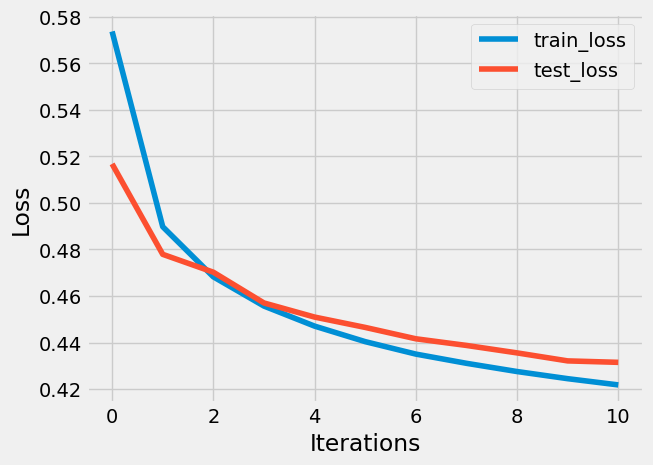

In [8]:
class Model(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        N_words = INPUT_WORDS_CNT
        N_variants = VARIANTS_CNT
        N_features = FEATURES_CNT

 


        # input is (N, N_words, N_variants, N_features)
        # output is (N, N_words, )

        # self.model = nn.Sequential(
        #     nn.Flatten(1), # (N, N_words* N_variants *N_features)
        #     nn.Linear(N_words* N_variants *N_features, 100),
        #     nn.Tanh(),
        #     nn.Linear(100, 100),
        #     nn.ReLU(),
        #     nn.Linear(100, TARGET_CLASSES_COUNT),
        #     # nn.Tanh(),
        #     # nn.Tanhshrink(),
        #     # nn.Sigmoid(),
        #     # nn.ReLU(),
        # )
        # encoder_layer = nn.TransformerEncoderLayer(d_model=N_variants *N_features,
        #                            nhead=1, dim_feedforward=10,
        #                            dropout=0.1, activation=nn.ReLU(), batch_first=True)
        self.model = nn.Sequential(
            nn.Flatten(2), # (N, N_words, N_variants *N_features)
            # nn.TransformerEncoder(encoder_layer, num_layers=1),encoder = 
            xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config)),
            xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config)),

            nn.Flatten(1), # (N, N_words* N_variants *N_features)
            # nn.Tanh(),
            nn.Linear(N_words* N_variants *N_features, TARGET_CLASSES_COUNT),
            # nn.ReLU(),
            # nn.Linear(100, TARGET_CLASSES_COUNT),
            # nn.Tanh(),
            # nn.Tanhshrink(),
            # nn.Sigmoid(),
            # nn.ReLU(),
        )


    def forward(self, x):
        return self.model(x)

    # buffer_size = 0
    # for buffer in model.buffers():
    #     buffer_size += buffer.nelement() * buffer.element_size()
    # return (param_size + buffer_size) / 1024**2

def train_model():
    model = Model()
    print(round(count_parameters(model), 3), "Mb of parameters")
    import importlib
    import trainer_mod
    importlib.reload(trainer_mod)
    Trainer = trainer_mod.Trainer

    optimizer = torch.optim.Adam(model.parameters(), 
                            lr=1e-3)
                            # betas=(0.5, 0.999))

    trainer = Trainer(model=model, 
                    # loss=nn.MSELoss(),
                    loss=nn.CrossEntropyLoss(),
                    optimizer=optimizer,
                    scheduler=None,
                    # scheduler=ReduceLROnPlateau(optimizer, factor=0.2, threshold=1e-5, patience=50),
                    additional_losses={
                        # "accurancy": lambda trainer: {"accurancy": 
                        #    float(torch.mean(torch.abs(trainer.model(trainer.x_test) - trainer.y_test)).detach())
                        # },
                    })

    trainer.set_data(input, output, train_test_split=0.9)
    try:
        trainer.train(400, batch=1000, trial=None, log=True)
    except KeyboardInterrupt:
        print("interrupted")
        pass
    
    trainer.plot_history(cutoff=0)
    return trainer
import os
# os.environ["CUDA_HOME"] = "/home/misha-sh/cuda"

trainer = train_model()
# run_proc(train_model)

In [11]:
input.shape

torch.Size([1670055, 5, 2, 54])

In [9]:
try: del _ 
except: pass
try: del __
except: pass
try: del ___
except: pass
try: del ____
except: pass
try: del _____
except: pass
try: del trainer
except: pass
try: del model
except: pass
try: del optimizer
except: pass
import gc
gc.collect()
torch.cuda.empty_cache() 

In [96]:
y_test, y_pred

(array([0, 2, 2, ..., 2, 0, 0]), array([0, 2, 2, ..., 1, 0, 0]))

<AxesSubplot: >

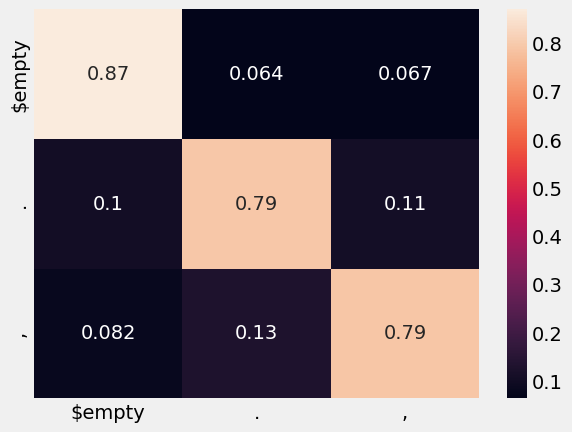

In [9]:
with torch.no_grad():
    trainer.model.eval()
    y_test_pred = trainer.model(trainer.x_test)
    _, y_pred_tags = torch.max(y_test_pred, dim = 1)
    y_pred = y_pred_tags.cpu().numpy()
    _, y_test_tags = torch.max(trainer.y_test, dim = 1)
    y_test = y_test_tags.cpu().numpy()
    
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred, normalize="true")).rename(
        columns=ID_TO_PUNCTUATION, index=ID_TO_PUNCTUATION)
sns.heatmap(confusion_matrix_df, annot=True)

In [ ]:
with torch.no_grad():
    model.eval()
    model.to

In [93]:
y_test.shape, y_pred_list.shape

((167122, 3), (1, 167122))

In [31]:
trainer.y_train

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0.])

In [ ]:
# scaler = GradScaler()

# for input, target in data:
#     with torch.autocast(device_type='cuda'):
#         output = model(input)
#         loss = loss_fn(output, target)
#     scaler.scale(loss).backward()
#     scaler.step(optimizer)
#     scaler.update()
